In [1]:
#Declarations
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def get_undistorted_img(img, mtx, dist):
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_img

findChessboardCorners failed: camera_cal/calibration1.jpg
findChessboardCorners failed: camera_cal/calibration4.jpg
findChessboardCorners failed: camera_cal/calibration5.jpg


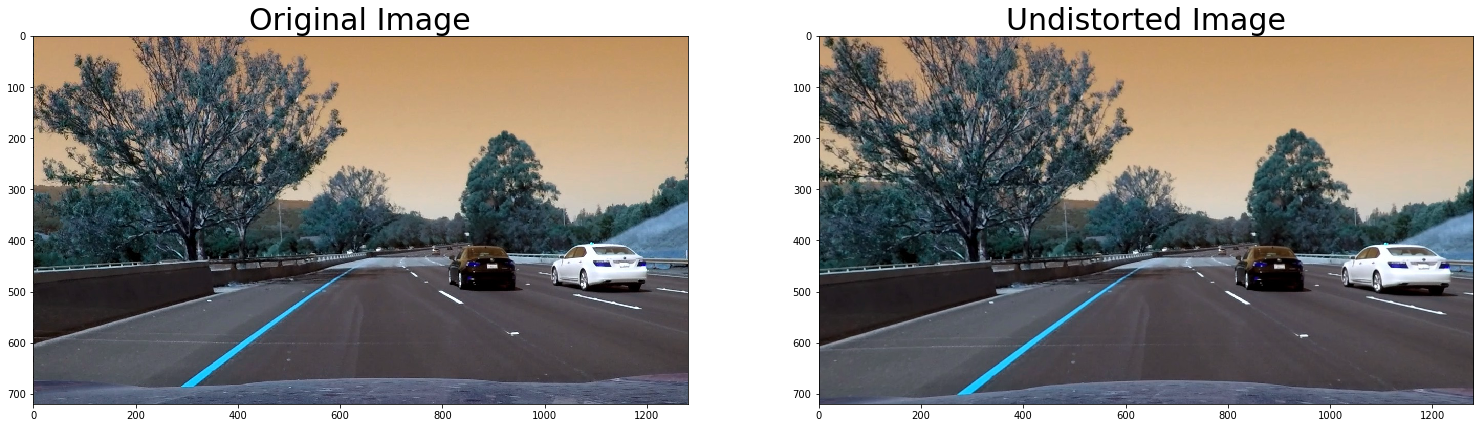

In [3]:
nx = 9 #inside x corners
ny = 6 #inside y corners

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)    
    else:
        print('findChessboardCorners failed:', fname)
        
#If the above code ran sucessfully, you should now have objpoints and imgpoints needed for camera calibration. 
#Run this code to calibrate, calculate distortion coefficients, and test undistortion on an image!

# Test undistortion on an calibration (chess board) image
#img = cv2.imread('camera_cal/calibration1.jpg')
#img_size = (img.shape[1], img.shape[0])

# Test undistortion on an test image
img = cv2.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])

#Caliberate the camera and compute the camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undistorted_img = get_undistorted_img(img, mtx, dist)
cv2.imwrite('camera_cal/pattern.jpg',undistorted_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [4]:
def define_thresholds():
    sx_thresh_min = 20
    sx_thresh_max = 100
    sx_thresh = (sx_thresh_min, sx_thresh_max)

    s_thresh_min = 170
    s_thresh_max = 255
    s_thresh = (s_thresh_min, s_thresh_max)

    l_thresh_min = 10
    l_thresh_max = 125
    l_thresh = (l_thresh_min, l_thresh_max)

In [5]:
def get_hls_image(img): 
    #img = np.copy(img) 
    #hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float) 
    return hls_img

In [6]:
def get_binary_img(img, s_thresh=(170, 200), sx_thresh=(10, 200)): #s_thresh = 170, 200 and sx_thresh = 20,100
    
    #hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float) 
    hls = get_hls_image(img)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1] 
    s_channel = hls[:,:,2] 
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    # Threshold x gradient 
    sxbinary = np.zeros_like(scaled_sobel) 
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 
    
    # Threshold color channel 
    s_binary = np.zeros_like(s_channel) 
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might 
    # be beneficial to replace this channel with something else. 
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary_img = np.zeros_like(sxbinary)
    combined_binary_img[(s_binary == 1) | (sxbinary == 1)] = 1
 
    ##height, width = gray.shape
    
    img_height, img_width, channel_num = img.shape
    '''
    print(img_height)
    print(img_width)
    print(channel_num)
    '''
    
    # region_of_interest (ROI) mask
    roi_mask = np.zeros_like(combined_binary_img)
    roi_vertices = np.array([[0,img_height-1], [img_width/2, int(0.5*img_height)], [img_width-1, img_height-1]], dtype=np.int32)
    #print("region_of_interest_vertices", roi_vertices)
    cv2.fillPoly(roi_mask, [roi_vertices], 1)
    
    masked_binary_img = cv2.bitwise_and(combined_binary_img, roi_mask)
    
    return masked_binary_img
    '''
    return color_binary_img, combined_binary_img 
    '''

In [7]:
def define_src_and_dst_for_warping():
    src_bottom_left = [220,720]
    src_bottom_right = [1110, 720]
    src_top_left = [570, 470]
    src_top_right = [720, 470]

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    dest_bottom_left = [320,720]
    dest_bottom_right = [920, 720]
    dest_top_left = [320, 1]
    dest_top_right = [920, 1]

In [8]:
def get_warped_img(masked_binary_img):
    
    # Vertices extracted manually for performing a perspective transform
    src_bottom_left = [220,720]
    src_bottom_right = [1110, 720]
    src_top_left = [570, 470]
    src_top_right = [720, 470]
    
    src = np.float32([src_bottom_left, src_bottom_right, src_top_right, src_top_left])
    
    dest_bottom_left = [320,720]
    dest_bottom_right = [920, 720]
    dest_top_left = [320, 1]
    dest_top_right = [920, 1]
    
    dst = np.float32([dest_bottom_left, dest_bottom_right, dest_top_right, dest_top_left])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    img_size = (masked_binary_img.shape[1], masked_binary_img.shape[0])

    warped_img = cv2.warpPerspective(masked_binary_img, M, img_size , flags=cv2.INTER_LINEAR)
    
    return warped_img, M, M_inv

In [9]:
def get_histogram_peaks(binary_warped_img):
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
    return histogram

In [10]:
def findAndPlotLanePixels(warped_img): 
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_img.shape[0] - (window+1)*window_height
        win_y_high = warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    '''
    print("left_fit", left_fit)
    print("right_fit", right_fit)
    '''
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    '''
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    return left_fit, right_fit

In [11]:
#Using lanes that have already been detected to find lane pixels
#This way you do not have to search for sliding window again once the lane is detected
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped" or "warped_image")
# It's now much easier to find line pixels!

def findAndPlotNextLanePixels(warped_img, left_fit, right_fit):
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    '''
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    '''
    print("ploty",ploty)
    print("left_fitx", left_fitx)
    print("right_fitx", right_fitx)
    '''
    
    return ploty, left_fitx, right_fitx

In [12]:
def get_radius_of_curvature(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    radius_of_curvature = (left_curve_rad + right_curve_rad)/2
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curve_rad, right_curve_rad, radius_of_curvature

In [13]:
def get_center_shift(img, left_fitx, right_fitx):
    center_of_lane = (left_fitx[719] + right_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_shifted_in_pixels = abs(img.shape[0]/2 - center_of_lane)
    center_shifted_in_meters = xm_per_pix * center_shifted_in_pixels
    return center_shifted_in_meters

In [14]:
def draw_driving_area(img, warped_img, M_inv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0)) #R=0;G=255;B=0

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [15]:
def adv_lane_detection_pipeline(img):
    
    #define_thresholds
    #define_thresholds()
    #variables
    sx_thresh_min = 20
    sx_thresh_max = 100
    sx_thresh = (sx_thresh_min, sx_thresh_max)

    s_thresh_min = 170
    s_thresh_max = 255
    s_thresh = (s_thresh_min, s_thresh_max)

    l_thresh_min = 10
    l_thresh_max = 125
    l_thresh = (l_thresh_min, l_thresh_max)

    #define_src_and_dst_for_warping
    #define_src_and_dst_for_warping()
    '''
    src_bottom_left = [220,720]
    src_bottom_right = [1110, 720]
    src_top_left = [570, 470]
    src_top_right = [720, 470]
    '''
    
    #get_masked_img
    masked_binary_img = get_binary_img(img, s_thresh, sx_thresh)    
    
    '''
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    dest_bottom_left = [320,720]
    dest_bottom_right = [920, 720]
    dest_top_left = [320, 1]
    dest_top_right = [920, 1]
    '''

    #get_warped_img
    warped_img, M, M_inv = get_warped_img(masked_binary_img)
    
    #get_histogram_peaks
    peakPixels = get_histogram_peaks(warped_img) #find peaks
    # Peak in the first half indicates the likely position of the left lane
    midpoint = np.int(peakPixels.shape[0]//2)
    leftx_peak = np.argmax(peakPixels[:midpoint])

    # Peak in the second half indicates the likely position of the right lane
    rightx_peak = np.argmax(peakPixels[midpoint:]) + midpoint

    #global left_fit 
    #global right_fit 
    left_fit = []
    right_fit = []
    
    #findAndPlotLanePixels
    left_fit, right_fit = findAndPlotLanePixels(warped_img)
    
    #findAndPlotNextLanePixels
    ploty, left_fitx, right_fitx = findAndPlotNextLanePixels(warped_img, left_fit, right_fit)
    
    #get_radius_of_curvature
    left_curve_rad, right_curve_rad, radius_of_curvature = get_radius_of_curvature(ploty, left_fitx, right_fitx)
    curvature_radius_string = "Radius of Curvature: %.2f m" % radius_of_curvature
    
    #get_center_shift
    center_shift = get_center_shift(img, left_fitx, right_fitx)
    center_shift_string = "Center Shift: %.2f m" % center_shift
    
    #draw_driving_area
    result = draw_driving_area(img, warped_img, M_inv, ploty, left_fitx, right_fitx)
    
    cv2.putText(result, curvature_radius_string, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    cv2.putText(result, center_shift_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    
    return result

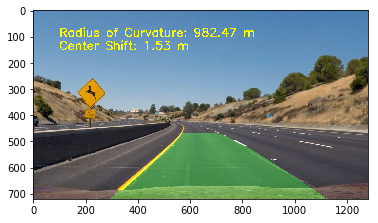

In [16]:
#Declarations
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Testing 
img = mpimg.imread('test_images/test2.jpg')
result = adv_lane_detection_pipeline(img)
plt.imshow(result)
plt.show()

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
video_output = 'Advanced_Lane_Detection.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(adv_lane_detection_pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video Advanced_Lane_Detection.mp4
[MoviePy] Writing video Advanced_Lane_Detection.mp4


100%|█████████▉| 1260/1261 [02:41<00:00,  8.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Advanced_Lane_Detection.mp4 

CPU times: user 2min 54s, sys: 57.3 s, total: 3min 51s
Wall time: 2min 41s
